In [1]:
# Hydrogen Risk Mapping and Material Compatibility Modelling in Urban Pipeline Networks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from scipy.integrate import simpson

### Part 1
Using Crank-Nicolson Hydrogen Diffusion Model for solving 1D diffusion in steel. Using this method as we need to solve partial differential equations.

In [3]:
def hydrogen_diffusion(D, L, T, Nx, Nt, C_surface):
    """
    Solves 1D hydrogen diffusion using the Crank-Nicolson method.
    Inputs:
    D: Diffusivity (m²/s)
    thickness: Membrane or wall thickness in m
    total_time: Total simulation time in s
    Nx: Number of spatial divisions
    Nt: Number of time steps
    C_surface: Constant concentration at the exposed surface in mol/m³
    Returns:
    x: Distance across the thickness of sample in m
    u: 2D array of concentration values over time
    t: Time points (s)
    """
    dx = L / Nx
    dt = T / Nt
    F = D * dt / dx**2

    x = np.linspace(0, L, Nx+1)
    t = np.linspace(0, T, Nt+1)
    u = np.zeros((Nt+1, Nx+1))
    u[0, :] = 0.0  # Initial concentration condition

    # Setting up the banded matrix coefficients 
    a, b, c = -F/2, 1 + F, -F/2
    ab = np.zeros((3, Nx-1))
    ab[0, 1:] = c
    ab[1, :] = b
    ab[2, :-1] = a

    # Time stepping loop
    for n in range(Nt):
        d = (F/2)*u[n,0:Nx-1] + (1-F)*u[n,1:Nx] + (F/2)*u[n,2:Nx+1]
        d[0] -= a * C_surface

        next_concentration = solve_banded((1, 1), ab, d)

        u[n+1,0] = C_surface           # Surface boundary
        u[n+1,1:Nx] = next_concentration
        u[n+1,Nx] = 0.0         # Backside boundary (vacuum or air)
    
    return x, u, t

In [4]:
# Constants for steel
D_steel = 1e-8         # for hydrogen in steel
L = 5e-3            # thickness of steel wall
T = 10000    # seconds
Nx = 50          # number of x points
Nt = 5000            # time steps
C_surface = 1.0      # mol/m³

# Run the simulation
x, u, t = hydrogen_diffusion(D_steel, L, T, Nx, Nt, C_surface)

print("u shape:", u.shape)

u shape: (5001, 51)


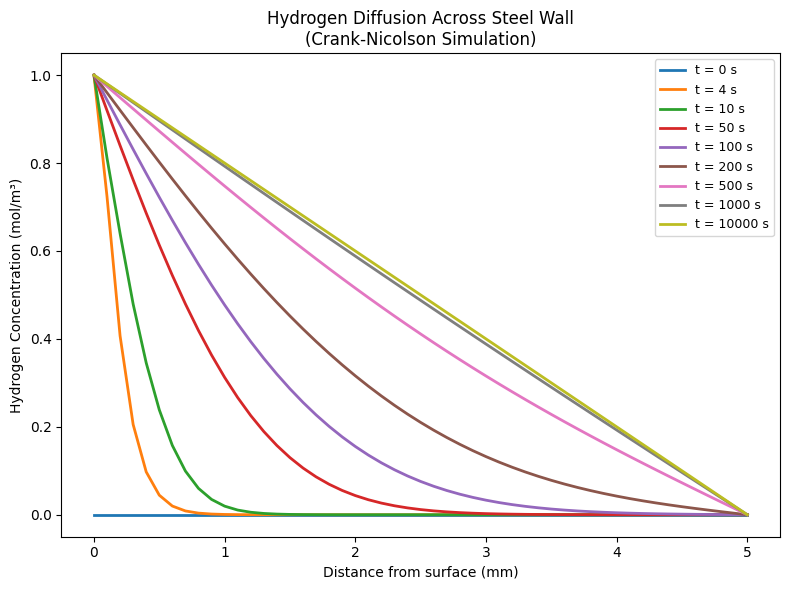

In [5]:
# Plot: Hydrogen Diffusion Evolution

list_time_percentage = [0, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 1.0]
time_steps_to_plot = (np.array(list_time_percentage) * Nt).astype(int)

plt.figure(figsize=(8,6))

for idx, step in enumerate(time_steps_to_plot):
    plt.plot(x*1e3, u[step,:], label=f"t = {t[step]:.0f} s", linewidth=2)
    
plt.xlabel("Distance from surface (mm)")
plt.ylabel("Hydrogen Concentration (mol/m³)")
plt.title("Hydrogen Diffusion Across Steel Wall\n(Crank-Nicolson Simulation)")
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

### Part 2

Comparing Numerical and Analytical Steady-State Solutions

In this part, we are comparing the numerical steady-state hydrogen concentration profile (obtained from the last time step of the previous simulation) with the analytical steady-state solution.

We also calculate:
- Root Mean Squared Error (RMSE)
- Coefficient of Determination (R²)

Comparing steady-state solutions:
Root Mean Squared Error (RMSE): 4.8621e-15 mol/m³
Coefficient of Determination (R²): 1.0000


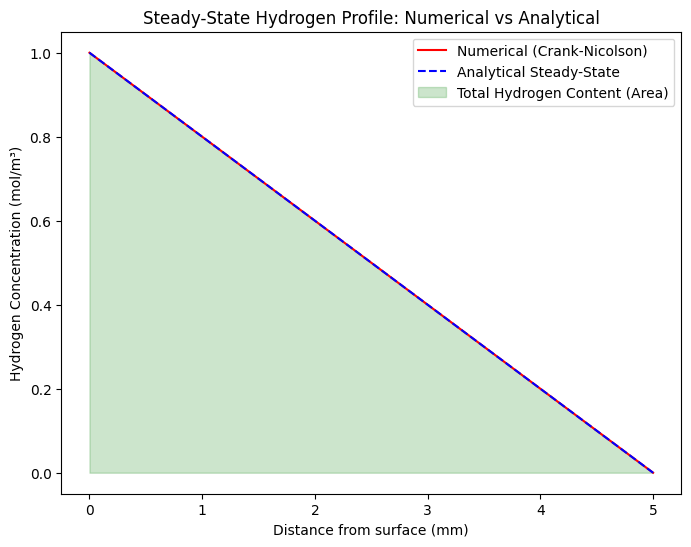

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# Analytical steady-state solution:
u_steady = C_surface * (1 - x / L)

# Numerical steady-statesolution: 
u_numerical = u[-1, :]

# Error calculation between numerical and analytical steady-state solution
rmse = np.sqrt(mean_squared_error(u_steady, u_numerical))
r2 = r2_score(u_steady, u_numerical)

print("Comparing steady-state solutions:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4e} mol/m³")
print(f"Coefficient of Determination (R²): {r2:.4f}")

# Plot comparison
plt.figure(figsize=(8,6))
plt.plot(x * 1e3, u_numerical, 'r-', label='Numerical (Crank-Nicolson)')
plt.plot(x * 1e3, u_steady, 'b--', label='Analytical Steady-State')
plt.fill_between(x * 1e3, 0, u_steady, color='green', alpha=0.2, label='Total Hydrogen Content (Area)')

plt.xlabel("Distance from surface (mm)")
plt.ylabel("Hydrogen Concentration (mol/m³)")
plt.title("Steady-State Hydrogen Profile: Numerical vs Analytical")
plt.legend()
plt.show()

### Part 3: Total Hydrogen Uptake in Different Materials

In this part, we are calculating the total amount of hydrogen absorbed (mol/m²) in different pipeline materials Carbon Steel, Cast Iron, HDPE over time.

Using:
- Using material properties - diffusivity (D) and solubility (S)
- Surface concentration calculated from: **C_surface = S × p_surface**

Then, we compute the area under the concentration profile at each time step using Simpson’s Rule to estimate total hydrogen uptake.

Carbon Steel: Final Total Hydrogen Uptake = 5.7250e-01 mol/m²
Cast Iron: Final Total Hydrogen Uptake = 2.4608e-01 mol/m²
HDPE: Final Total Hydrogen Uptake = 1.1283e+00 mol/m²


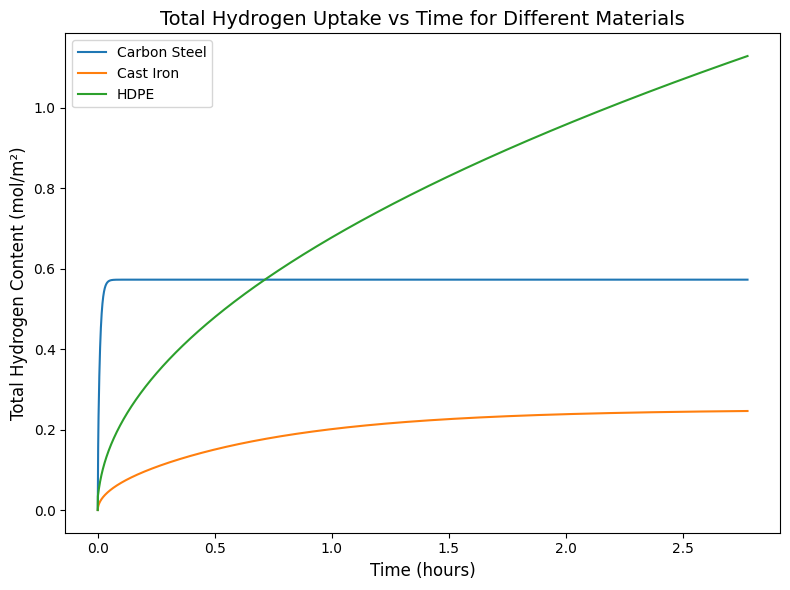

In [7]:
from scipy.integrate import simpson

materials = {'Carbon Steel': {'D': 7.32e-8, 'S': 2.29e-3},
    'Cast Iron': {'D': 1.0e-9, 'S': 1.0e-3},
    'HDPE': {'D': 1.0e-10, 'S': 1.0e-2}} # material properties

p_surface = 1e5  # Pa, pressure on surface
uptake_dict = {}

plt.figure(figsize=(8,6))

for material, props in materials.items():
    D = props['D']
    S = props['S']
    C_surface = S * p_surface  # mol/m³

    x, u, t = hydrogen_diffusion(D, L, T, Nx, Nt, C_surface)

    # Calculate area under each curve-total hydrogen content
    total_hydrogen_uptake = np.array([simpson(u_n,x= x) for u_n in u])
    uptake_dict[material] = total_hydrogen_uptake[-1]

    plt.plot(t / 3600, total_hydrogen_uptake, label=material)
    print(f"{material}: Final Total Hydrogen Uptake = {total_hydrogen_uptake[-1]:.4e} mol/m²")

# Final plot labels and title
plt.xlabel("Time (hours)", fontsize=12)
plt.ylabel("Total Hydrogen Content (mol/m²)", fontsize=12)
plt.title("Total Hydrogen Uptake vs Time for Different Materials", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


### Part 4 (flux & leakage calculation)

In this part, we estimate the hydrogen leakage through pipe walls made of different materials.

Steps:
1. Compute the steady-state flux (J) using the slope of the concentration profile near the surface.
2. Use this flux to calculate:
   - Hydrogen leaked per hour (mol/hr)
   - Total moles of hydrogen stored in the pipe
   - Percentage leakage per hour

Assumptions:
- Hydrogen is in pipe at 10 atm, 25 °C
- Steady-state is achieved over time
- Fixed pipe geometry(100 m long, 30 cm diameter)


In [8]:
import pandas as pd
from scipy.stats import linregress

# Constants
L = 5e-3               # Thickness (5 mm)
T = 5e5                # Total simulation time (500,000 seconds ~138 hours)
p_surface = 1e6        # Surface hydrogen pressure (Pa)
d_pipe = 2           # Pipe diameter (m)
L_pipe = 100           # Pipe length (m)
P = 10 * 1.013e5       # Pressure inside pipe (Pa)
T_gas = 298.15         # Temperature (K)
R = 8.314              # Gas constant (J/mol/K)

def calculate_flux(x, u_steady, D, N_fit=5):
    """
    Calculates steady-state flux using linear fit near surface.
    """
    x_fit = x[:N_fit]
    u_fit = u_steady[:N_fit]
    slope, intercept, r_value, p_value, std_err = linregress(x_fit, u_fit)
    J = -D * slope
    return J, r2**2

def calculate_leakage(J, d_pipe, L_pipe, P, T_gas, R):
    """
    Estimates hydrogen leakage in mol/hr and % of total pipe gas content.
    """
    A_pipe = np.pi * d_pipe * L_pipe               # External surface area of pipeline
    V_pipe = np.pi * (d_pipe/2)**2 * L_pipe        # Internal volume of pipeline
    flux_hr = J * 3600                             # mol/m²/hr
    leak_mol = flux_hr * A_pipe                 # mol/hr
    total_mol = (P * V_pipe) / (R * T_gas)         # Using ideal gas law
    leakage_pct = (leak_mol / total_mol) * 100
    return flux_hr, leak_mol, total_mol, leakage_pct

results = []
for material, props in materials.items():
    D = props['D']
    S = props['S']
    C_surface = S * p_surface

    x, u, t = hydrogen_diffusion(D, L, T, Nx, Nt, C_surface)

    # Calculate flux
    flux_ss, r2_fit = calculate_flux(x, u[-1, :], D)

    # Calculate leakage
    flux_hr, leak_hr, n_total, leakage_pct = calculate_leakage(flux_ss, d_pipe, L_pipe, P, T_gas, R)

    # Append results in list
    results.append({'Material': material,
        'D': D,
        'S': S,
        'Steady State Flux': flux_ss,
        'Flux per Hour': flux_hr,
        'Leakage per Hour': leak_hr,
        'Total Gas in Pipe': n_total,
        'Leakage Percentage per Hour(%)': leakage_pct,
        'R² of Fit Near Surface': r2_fit})

# Tables
input_table = pd.DataFrame(materials).T.reset_index()
input_table.columns = ['Material', 'Diffusivity D (m²/s)', 'Solubility S (mol/m³/Pa)']

output_table = pd.DataFrame(results)

print("Material Properties Used:")
display(input_table)

print("Hydrogen Leakage Estimates:")
display(output_table)

Material Properties Used:


,Material,Diffusivity D (m²/s),Solubility S (mol/m³/Pa)
0,Carbon Steel,7.320000e-08,0.00229
1,Cast Iron,1.000000e-09,0.00100
2,HDPE,1.000000e-10,0.01000


Hydrogen Leakage Estimates:


,Material,D,S,Steady State Flux,Flux per Hour,Leakage per Hour,Total Gas in Pipe,Leakage Percentage per Hour(%),R² of Fit Near Surface
0,Carbon Steel,7.320000e-08,0.00229,0.033526,120.692171,75833.127736,128385.05876,59.066942,1.0
1,Cast Iron,1.000000e-09,0.00100,0.000200,0.720000,452.389342,128385.05876,0.352369,1.0
2,HDPE,1.000000e-10,0.01000,0.000200,0.720000,452.389345,128385.05876,0.352369,1.0


### Part 5: Fracture Toughness Degradation due to Hydrogen Embrittlement

Using the total hydrogen content from Part 3, we compute the average hydrogen concentration in the material.

Analyze fracture toughness (K_IC) using:
- β (m³/mol): A material-dependent constant that captures embrittlement sensitivity
- HEI (%): Hydrogen Embrittlement Index = % degradation in toughness

The bar plot visually compares fracture toughness before and after hydrogen exposure for different materials.

Fracture Toughness Degradation Summary:


,Material,Original K_IC₀ (MPa√m),Reduced K_IC_H (MPa√m),Average [H] (mol/m³),β (m³/mol),HEI (%)
0,Carbon Steel,100,70,1.14e+02,2.62e-03,30.00
1,Cast Iron,80,60,4.92e+01,5.08e-03,25.00
2,HDPE,20,18,2.26e+02,4.43e-04,10.00


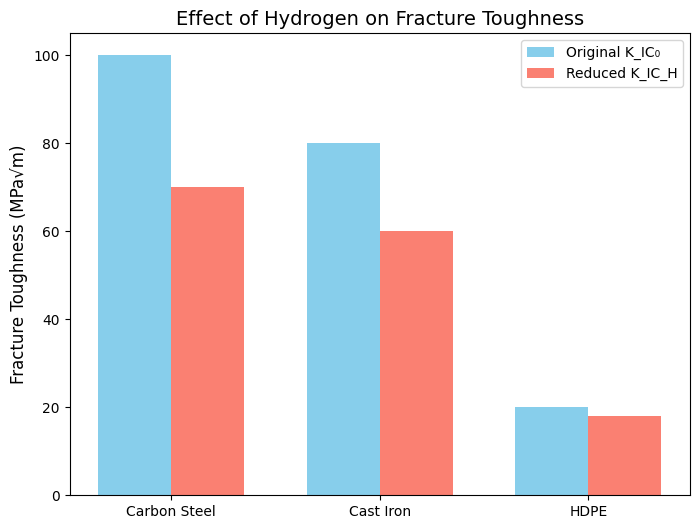

In [9]:
# Fracture toughness values from literature in MPa(m)^1/2
K_IC0 = [100, 80, 20]   
K_IC_H = [70, 60, 18]  

materials_list = list(materials.keys())

avg_concentrations = []  # Initial lists
beta_values = []         
HEI_values = []       

# total H uptake in mol/m²
for i, material in enumerate(materials_list): #  Retrieves the final total hydrogen uptake from part 3
    uptake = uptake_dict[material]             
    C_H = uptake / L                           

    avg_concentrations.append(C_H)

    K0 = K_IC0[i]
    KH = K_IC_H[i]
    HEI = 1 - (KH / K0)
    beta = HEI / C_H

    HEI_values.append(HEI)
    beta_values.append(beta)

# Format and display results
fracture_table = pd.DataFrame({'Material': materials_list,
    'Original K_IC₀ (MPa√m)': K_IC0,
    'Reduced K_IC_H (MPa√m)': K_IC_H,
    'Average [H] (mol/m³)': [f"{c:.2e}" for c in avg_concentrations],
    'β (m³/mol)': [f"{b:.2e}" for b in beta_values],
    'HEI (%)': [f"{h*100:.2f}" for h in HEI_values]})

print("Fracture Toughness Degradation Summary:")
display(fracture_table)

# comparison plot: Fracture toughness before vs after
x = np.arange(len(materials_list))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
bars1 = ax.bar(x - width/2, K_IC0, width, label='Original K_IC₀', color='skyblue')
bars2 = ax.bar(x + width/2, K_IC_H, width, label='Reduced K_IC_H', color='salmon')

ax.set_ylabel("Fracture Toughness (MPa√m)", fontsize=12)
ax.set_title("Effect of Hydrogen on Fracture Toughness", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(materials_list)
ax.legend()

### Part 6 Reduced Lifetime Estimation Due to Hydrogen Embrittlement

Estimating how hydrogen exposure reduces the effective lifetime of pipeline materials, using:

${Reduced Lifetime} = (1 - \text{HEI}) \times \text{Original Lifetime}$

This assumes that fracture toughness degradation proportionally reduces the service life.

,HEI (%),Original Lifetime (years),Reduced Lifetime (years)
Carbon Steel,30.00,100,70.00
Cast Iron,25.00,100,75.00
HDPE,10.00,100,90.00


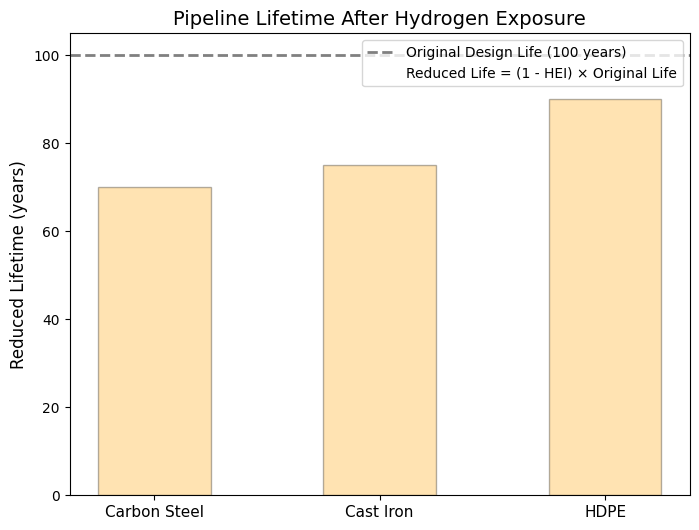

In [10]:
# Lets assume initial lifetime of all material is 100
original_lifetime = 100

# Calculate reduced lifetime for each material using HEI values
reduced_lifetimes = [(1 - hei) * original_lifetime for hei in HEI_values]

# Table
lifetime_table = pd.DataFrame({'HEI (%)': [f"{hei*100:.2f}" for hei in HEI_values],
    'Original Lifetime (years)': original_lifetime,
    'Reduced Lifetime (years)': [f"{rl:.2f}" for rl in reduced_lifetimes]}, index=materials_list)

display(lifetime_table)

# Plot r
x = np.arange(len(materials_list))
bar_width = 0.5
fig, ax = plt.subplots(figsize=(8,6))
bars = ax.bar(x, reduced_lifetimes, width=bar_width,
              color='orange', alpha=0.3, edgecolor='black')
ax.set_ylabel("Reduced Lifetime (years)", fontsize=12)
ax.set_title("Pipeline Lifetime After Hydrogen Exposure", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(materials_list, fontsize=11)
ax.axhline(y=original_lifetime, color='grey', linestyle='--', linewidth=2, label="Original Design Life (100 years)")
ax.plot([], [], ' ', label=r"Reduced Life = (1 - HEI) × Original Life")
ax.legend(fontsize=10, loc='upper right')
plt.show()


### Part 7: Pipeline Compatibility Index (PCI) and Risk Categorization

To assess pipeline material suitability under hydrogen exposure, we define a Pipeline Compatibility Index (PCI):

${PCI} = 0.5 \times \text{HEI} + 0.3 \times \text{Leakage Percentage} + 0.2 \times \text{Lifetime Reduction Percentage}$

Where:
- **HEI**: Hydrogen Embrittlement Index
- **Leakage %**: from flux analysis
- **Lifetime Reduction %**: from fracture degradation

Based on the PCI value, each material is classified into one of four risk categories:
- Safe: PCI < 0.3 (green)
- Moderate Risk: 0.3 ≤ PCI < 0.6 (yellow)
- Needs Retrofit: 0.6 ≤ PCI < 0.8 (orange)
- Unsafe: PCI ≥ 0.8 (red)


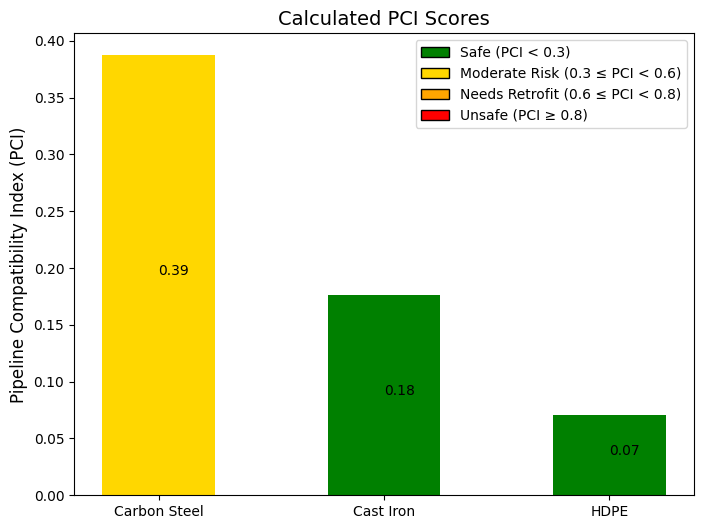

In [11]:
from matplotlib.patches import Patch

# PCI for each material
pci_scores = []

for i in range(len(materials_list)):
    hei = HEI_values[i]
    leakage_pct = results[i]['Leakage Percentage per Hour(%)']
    lifetime_pct = hei * 100  

    pci = 0.5 * hei + 0.3 * (leakage_pct / 100) + 0.2 * (lifetime_pct / 100)
    pci_scores.append(pci)

# Assigning colors based on PCI category
pci_colors = []
for score in pci_scores:
    if score < 0.3:
        pci_colors.append('green')     # Safe
    elif score < 0.6:
        pci_colors.append('gold')      # Moderate risk
    elif score < 0.8:
        pci_colors.append('orange')    # Needs retrofit
    else:
        pci_colors.append('red')       # Unsafe

# Plotting PCI scores
x = np.arange(len(materials_list))
fig, ax = plt.subplots(figsize=(8,6))
bar_width = 1
bars = ax.bar(x, pci_scores, color=pci_colors, width=0.5)

ax.set_ylabel("Pipeline Compatibility Index (PCI)", fontsize=12)
ax.set_title("Calculated PCI Scores", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(materials_list)

# Labels inside bars
for i, bar in enumerate(bars):
    value = pci_scores[i]
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,f"{value:.2f}")

legend_elements = [Patch(facecolor='green', edgecolor='black', label='Safe (PCI < 0.3)'),
    Patch(facecolor='gold', edgecolor='black', label='Moderate Risk (0.3 ≤ PCI < 0.6)'),
    Patch(facecolor='orange', edgecolor='black', label='Needs Retrofit (0.6 ≤ PCI < 0.8)'),
    Patch(facecolor='red', edgecolor='black', label='Unsafe (PCI ≥ 0.8)')]

ax.legend(handles=legend_elements, fontsize=10)
plt.show()